In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

from datetime import datetime
from matplotlib import pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm

## Parameter

In [2]:
n_epoch = 30
batch_size = 1
beta1 = 0.5
beta2 = 0.999
lr = 0.0001

lambda_x = 7
lambda_c = 3
lambda_s = 3
lambda_cyc = 10

In [3]:
cuda = True if torch.cuda.is_available() else False
cuda

True

## Dataset

In [4]:
class AFHQ(Dataset):
    def __init__(self, path, target, transforms=None):
        self.path_dataset = path + '\\' + target
        self.transforms = transforms
        self.images = glob(self.path_dataset + '\\*.jpg')

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        return image

    def __len__(self):
        return len(self.images)

In [5]:
transform = transforms.Compose([
  transforms.Resize((256, 256)),
  transforms.RandomHorizontalFlip(0.5),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
DATA_PATH = 'E:\\DATASET\\afhq\\train'

dataset_dog = AFHQ(path=DATA_PATH, target='dog', transforms=transform)
dataset_cat = AFHQ(path=DATA_PATH, target='cat', transforms=transform)

In [7]:
print('dataset_dog : %7d\ndataset_cat : %7d' %(len(dataset_dog), len(dataset_cat)))

dataset_dog :    4739
dataset_cat :    5153


In [8]:
dataloader_dog = DataLoader(dataset=dataset_dog, batch_size=batch_size, shuffle=True)
dataloader_cat = DataLoader(dataset=dataset_cat, batch_size=batch_size, shuffle=True)

In [9]:
data_dog = next(iter(dataloader_dog))
data_cat = next(iter(dataloader_cat))

In [10]:
def get_plt_image(img):
    return transforms.functional.to_pil_image(0.5 * img + 0.5)

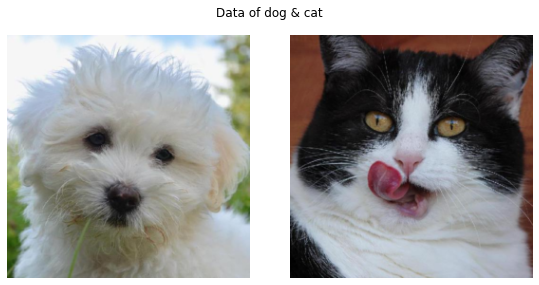

In [11]:
plt.figure(figsize=(8, 4))
plt.suptitle('Data of dog & cat')

plt.subplot(1, 2, 1)
plt.imshow(get_plt_image(data_dog[0]))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(get_plt_image(data_cat[0]))
plt.axis('off')

plt.tight_layout()
plt.savefig('./history/data.png', dpi=300)
plt.show()

## Model

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.Tensor(num_features).uniform_())
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        # print(x.size())
        if x.size(0) == 1:
            # These two lines run much faster in pytorch 0.4 than the two lines listed below.
            mean = x.view(-1).mean().view(*shape)
            std = x.view(-1).std().view(*shape)
        else:
            mean = x.view(x.size(0), -1).mean(1).view(*shape)
            std = x.view(x.size(0), -1).std(1).view(*shape)

        x = (x - mean) / (std + self.eps)

        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            x = x * self.gamma.view(*shape) + self.beta.view(*shape)
        return x

In [13]:
class AdaptiveInstanceNorm2d(nn.Module):
    def __init__(self):
        super(AdaptiveInstanceNorm2d, self).__init__()

        self.eps = 1e-5
        self.y_mean = None
        self.y_std = None

    def forward(self, x):
        assert self.y_mean is not None and self.y_std is not None, "Set AdaIN first"

        n, c, h, w = x.size()

        x_mean = x.view(n, c, -1).mean(dim=2).view(n, c, 1, 1).expand(x.size())
        x_var = x.view(n, c, -1).var(dim=2) + self.eps
        x_std = x_var.sqrt().view(n, c, 1, 1).expand(x.size())

        y_mean = self.y_mean.view(n, c, 1, 1).expand(x.size())
        y_std = self.y_std.view(n, c, 1, 1).expand(x.size())

        norm = y_std * ((x - x_mean) / (x_std + self.eps)) + y_mean
        return norm

In [14]:
class Residual(nn.Module):
    def __init__(self, in_feature, out_feature, norm_mode='in'):
        super(Residual, self).__init__()

        if norm_mode == 'in':
            norm = nn.InstanceNorm2d(out_feature)
        elif norm_mode == 'adain':
            norm = AdaptiveInstanceNorm2d()

        conv = nn.Conv2d(in_feature, out_feature, kernel_size=3, padding=1, padding_mode='reflect')
        relu = nn.ReLU()

        model = []
        for _ in range(2):
            model += [conv, norm, relu]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return x + self.model(x)

In [15]:
class xk(nn.Module):
    def __init__(self, name, in_feature, out_feature, norm_mode='in'):
        super(xk, self).__init__()

        model = []
        norm = [nn.InstanceNorm2d(out_feature)]
        relu = [nn.ReLU()]

        if name == 'c7s1':
            conv = [nn.Conv2d(in_feature, out_feature, kernel_size=7, stride=1, padding=3, padding_mode='reflect')]

        elif name == 'dk':
            conv = [nn.Conv2d(in_feature, out_feature, kernel_size=4, stride=2, padding=1, padding_mode='reflect')]

        elif name == 'uk':
            conv = []
            conv += [nn.Upsample(scale_factor=2, mode='nearest')]
            conv += [nn.Conv2d(in_feature, out_feature, kernel_size=5, stride=1, padding=2)]
            
            norm = [LayerNorm(out_feature)]

        model += conv
        model += norm
        model += relu

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [16]:
class ContentEncoder(nn.Module):
    def __init__(self):
        super(ContentEncoder, self).__init__()

        self.model = nn.Sequential(
            # Down-sampling
            xk('c7s1', 3, 64),
            xk('dk', 64, 128),
            xk('dk', 128, 256),

            # Residual Blocks
            Residual(256, 256, norm_mode='in'),
            Residual(256, 256, norm_mode='in'),
            Residual(256, 256, norm_mode='in'),
            Residual(256, 256, norm_mode='in')
        )

    def forward(self, x):
        return self.model(x)


In [17]:
class StyleEncoder(nn.Module):
    def __init__(self):
        super(StyleEncoder, self).__init__()

        self.model = nn.Sequential(
            # Down-sampling
            xk('c7s1', 3, 64),
            xk('dk', 64, 128),
            xk('dk', 128, 256),
            xk('dk', 256, 256),
            xk('dk', 256, 256)
        )

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # FC
        self.fc = nn.Linear(256, 8)

    def forward(self, x):
        x = self.model(x)
        x = self.gap(x)
        x = self.fc(x.flatten(start_dim=1))

        return x

In [18]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            # Residual
            Residual(256, 256, norm_mode='adain'),
            Residual(256, 256, norm_mode='adain'),
            Residual(256, 256, norm_mode='adain'),
            Residual(256, 256, norm_mode='adain'),
            
            # Upsampling
            xk('uk', 256, 128),
            xk('uk', 128, 64),
            
            # c7s1-3
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3, padding_mode='reflect'),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [19]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2048)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.D1 = self.set_model()
        self.D2 = self.set_model()
        self.D3 = self.set_model()

        self.downsample = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)

    def set_model(self):
        model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=1)
        )

        return model

    def forward(self, x):
        out_d1 = self.D1(x)
        x = self.downsample(x)
        out_d2 = self.D2(x)
        x = self.downsample(x)
        out_d3 = self.D3(x)
        
        return [out_d1, out_d2, out_d3]

In [21]:
class MUNIT(nn.Module):
    def __init__(self):
        super(MUNIT, self).__init__()

        self.content_encoder = ContentEncoder()
        self.style_encoder = StyleEncoder()
        self.mlp = MLP()
        self.decoder = Decoder()  # Generator
        self.discriminator = Discriminator()
        
        self.gen_params = list(self.content_encoder.parameters()) + list(self.style_encoder.parameters()) + list(self.mlp.parameters()) + list(self.decoder.parameters())
        self.dis_params = list(self.discriminator.parameters())

    def encode(self, x):
        content = self.content_encoder(x)
        style = self.style_encoder(x)
        return content, style

    def decode(self, content, style):
        param = self.mlp(style)
        self.set_adain(param)

        return self.decoder(content)

    def discriminate(self, x):
        return self.discriminator.forward(x)
    
    def loss_gan(self, results, target):
        loss = 0

        for result in results:
            loss += torch.mean((result - target) ** 2)

        return loss
    
    def set_adain(self, param):
        cnt = 0
        for m in self.decoder.modules():
            if m.__class__.__name__ == 'AdaptiveInstanceNorm2d':
                m.y_mean = param[:, cnt*256:(cnt+1)*256]
                m.y_std = param[:, (cnt+1)*256:(cnt+2)*256]
                cnt += 2

In [22]:
munit_dog = MUNIT().cuda()
munit_cat = MUNIT().cuda()

## Train

In [23]:
history = {'G': [0] * n_epoch, 'D': [0] * n_epoch, 'lr': []}

# 결과 history를 출력하기 위한 fix random style code
style_fix_dog = torch.autograd.Variable(torch.randn((1, 8)).cuda())
style_fix_cat = torch.autograd.Variable(torch.randn((1, 8)).cuda())

In [24]:
len(munit_dog.gen_params), len(munit_dog.dis_params)

(50, 30)

In [25]:
len(munit_dog.gen_params + munit_cat.gen_params)

100

In [26]:
optimizer_gen = torch.optim.Adam(munit_dog.gen_params + munit_cat.gen_params, lr=lr, betas=(beta1, beta2))
optimizer_dis = torch.optim.Adam(munit_dog.dis_params + munit_cat.dis_params, lr=lr, betas=(beta1, beta2))

scheduler_gen = torch.optim.lr_scheduler.StepLR(optimizer_gen, step_size=3, gamma=0.5)
scheduler_dis = torch.optim.lr_scheduler.StepLR(optimizer_dis, step_size=3, gamma=0.5)

In [27]:
data_dog = data_dog.cuda()
data_cat = data_cat.cuda()

In [28]:
loss_l1 = torch.nn.L1Loss()

In [29]:
for epoch in range(n_epoch):
    time_start = datetime.now()
    munit_dog.train()
    munit_cat.train()
    
    for i in tqdm(range(len(dataloader_dog))):
        image_dog = next(iter(dataloader_dog)).cuda()
        image_cat = next(iter(dataloader_cat)).cuda()
     
        '''
        Generator
        '''
        optimizer_gen.zero_grad()
        
        style_rand_dog = torch.autograd.Variable(torch.randn((1, 8)).cuda())
        style_rand_cat = torch.autograd.Variable(torch.randn((1, 8)).cuda())
   
        
        # encode
        content_dog, style_dog = munit_dog.encode(image_dog)
        content_cat, style_cat = munit_cat.encode(image_cat)

        # decode(origin domain)
        hat_dog = munit_dog.decode(content_dog, style_dog)
        hat_cat = munit_cat.decode(content_cat, style_cat)

        # decode(differ domain)
        recon_dog = munit_dog.decode(content_cat, style_rand_dog) 
        recon_cat = munit_cat.decode(content_dog, style_rand_cat) 

        # encode(latent reconstruction)
        content_hat_cat, style_hat_rand_dog = munit_dog.encode(recon_dog)
        content_hat_dog, style_hat_rand_cat = munit_cat.encode(recon_cat)
        
        # decode(cycle consistency)
        recon_cyc_dog = munit_dog.decode(content_hat_dog, style_dog)
        recon_cyc_cat = munit_cat.decode(content_hat_cat, style_cat)

        # loss_adversarial
        loss_gan = munit_dog.loss_gan(munit_dog.discriminate(recon_dog), 1) + \
                   munit_cat.loss_gan(munit_cat.discriminate(recon_cat), 1)

        # loss_reconstruction
        recon_img_dog = loss_l1(hat_dog, image_dog)
        recon_img_cat = loss_l1(hat_cat, image_cat)
        recon_latent_c_dog = loss_l1(content_hat_dog, content_dog)
        recon_latent_c_cat = loss_l1(content_hat_cat, content_cat)
        recon_latent_s_dog = loss_l1(style_hat_rand_dog, style_rand_dog)
        recon_latent_s_cat = loss_l1(style_hat_rand_cat, style_rand_cat)
        recon_cyc_dog = loss_l1(recon_cyc_dog, image_dog)
        recon_cyc_cat = loss_l1(recon_cyc_cat, image_cat)

        # total loss
        loss_G = loss_gan + lambda_x * (recon_img_dog + recon_img_cat) + \
                 lambda_c * (recon_latent_c_dog + recon_latent_c_cat) + \
                 lambda_s * (recon_latent_s_dog + recon_latent_s_cat) + \
                 lambda_cyc * (recon_cyc_dog + recon_cyc_cat)
        history['G'][epoch] += loss_G.item()

        loss_G.backward()
        optimizer_gen.step()

        '''
        Discriminator
        '''
        optimizer_dis.zero_grad()
        
        # encode
        content_dog, _ = munit_dog.encode(image_dog)
        content_cat, _ = munit_cat.encode(image_cat)

        # decode(differ domain)
        recon_dog = munit_dog.decode(content_cat, style_rand_dog)
        recon_cat = munit_cat.decode(content_dog, style_rand_cat)

        # loss_adversarial(real image)
        loss_gan_real = munit_dog.loss_gan(munit_dog.discriminate(image_dog), 1) + \
                        munit_cat.loss_gan(munit_cat.discriminate(image_cat), 1)

        # loss_adversarial(fake image)
        loss_gan_fake = munit_dog.loss_gan(munit_dog.discriminate(recon_dog), 0) + \
                        munit_cat.loss_gan(munit_cat.discriminate(recon_cat), 0)

        # total loss
        loss_D = loss_gan_real + loss_gan_fake
        history['D'][epoch] += loss_D.item()

        loss_D.backward()
        optimizer_dis.step()
        
    '''
    scheduler
    '''
    scheduler_gen.step()
    scheduler_dis.step()

    '''
    history
    '''
    history['lr'].append(optimizer_gen.param_groups[0]['lr'])
    history['G'][epoch] /= len(dataloader_dog)
    history['D'][epoch] /= len(dataloader_dog)
    
    munit_dog.eval()
    munit_cat.eval()
    with torch.no_grad():
        # encode
        content_dog, style_dog = munit_dog.encode(data_dog)
        content_cat, style_cat = munit_cat.encode(data_cat)

        # decode(differ domain)
        recon_dog = munit_dog.decode(content_cat, style_fix_dog)
        recon_cat = munit_cat.decode(content_dog, style_fix_cat)
        
        test_dog = get_plt_image(recon_dog[0])
        test_cat = get_plt_image(recon_cat[0])
        
        test_dog.save('./history/test/dog_' + str(epoch).zfill(3) + '.png')
        test_cat.save('./history/test/cat_' + str(epoch).zfill(3) + '.png')

    '''
    print
    '''
    time_end = datetime.now() - time_start
    print('%2dM %2dS / Epoch %2d' % (*divmod(time_end.seconds, 60), epoch + 1))
    print('loss_G: %.5f, loss_D: %.5f \n' % (history['G'][epoch], history['D'][epoch]))


  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

79M 35S / Epoch  1
loss_G: 13.96675, loss_D: 2.75272 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

79M 31S / Epoch  2
loss_G: 12.39145, loss_D: 2.59740 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

79M 19S / Epoch  3
loss_G: 12.29072, loss_D: 2.34764 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

79M 13S / Epoch  4
loss_G: 12.10507, loss_D: 1.99242 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

79M 14S / Epoch  5
loss_G: 12.22708, loss_D: 1.92478 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

78M 19S / Epoch  6
loss_G: 12.33228, loss_D: 1.91228 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

78M 19S / Epoch  7
loss_G: 12.24301, loss_D: 1.78062 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

78M 22S / Epoch  8
loss_G: 12.24989, loss_D: 1.77028 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

78M 21S / Epoch  9
loss_G: 12.27425, loss_D: 1.77812 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

78M 21S / Epoch 10
loss_G: 12.14903, loss_D: 1.68082 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

78M 22S / Epoch 11
loss_G: 12.19876, loss_D: 1.69806 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

78M 19S / Epoch 12
loss_G: 12.20769, loss_D: 1.67982 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

78M 21S / Epoch 13
loss_G: 12.11196, loss_D: 1.61685 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

78M 19S / Epoch 14
loss_G: 12.14148, loss_D: 1.61289 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

78M 19S / Epoch 15
loss_G: 12.11838, loss_D: 1.60156 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

78M 21S / Epoch 16
loss_G: 12.02978, loss_D: 1.56685 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

79M 26S / Epoch 17
loss_G: 12.03526, loss_D: 1.57639 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

80M  3S / Epoch 18
loss_G: 12.04818, loss_D: 1.56754 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

80M  3S / Epoch 19
loss_G: 12.01031, loss_D: 1.55180 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

80M  3S / Epoch 20
loss_G: 12.00254, loss_D: 1.55103 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

80M  3S / Epoch 21
loss_G: 12.05254, loss_D: 1.54418 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

80M  2S / Epoch 22
loss_G: 12.03266, loss_D: 1.53079 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

80M  3S / Epoch 23
loss_G: 12.02033, loss_D: 1.53090 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

80M  4S / Epoch 24
loss_G: 11.99894, loss_D: 1.53264 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

80M  5S / Epoch 25
loss_G: 11.98745, loss_D: 1.52262 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

80M  4S / Epoch 26
loss_G: 11.97977, loss_D: 1.51512 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

80M  4S / Epoch 27
loss_G: 12.00452, loss_D: 1.52047 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

80M  6S / Epoch 28
loss_G: 11.99636, loss_D: 1.51289 



  0%|                                                                                         | 0/4739 [00:00<?, ?it/s]

80M  4S / Epoch 29
loss_G: 11.98201, loss_D: 1.51625 



100%|████████████████████████████████████████████████████████████████████████████| 4739/4739 [1:20:04<00:00,  1.01s/it]


80M  4S / Epoch 30
loss_G: 12.01889, loss_D: 1.52226 



## Save

In [30]:
torch.save(munit_dog.state_dict(), './history/munit_dog.pt')
torch.save(munit_cat.state_dict(), './history/munit_cat.pt')

## Graph

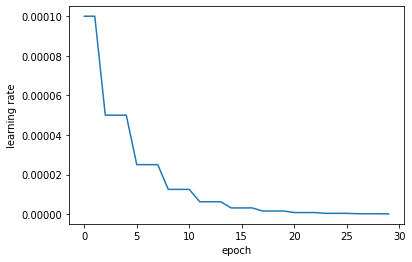

In [31]:
# history_lr
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.plot(range(n_epoch), history['lr'])

plt.savefig('./history/history_lr.png', dpi=300)
plt.show()

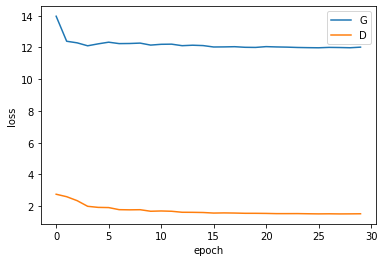

In [32]:
# history_loss
plt.plot(range(n_epoch), history['G'])
plt.plot(range(n_epoch), history['D'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['G', 'D'])

plt.savefig('./history/history_loss.png', dpi=300)
plt.show()